# Installing Dependencies

In [ ]:
!pip install segmentation-models-pytorch

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/Deloitte Analytathon 2024')
# Get the current working directory path
current_dir = Path.cwd()

# Print the current working directory
print(f"Current working directory: {current_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current working directory: /content/drive/MyDrive/Deloitte Analytathon 2024


# Importing Dependencies

In [3]:
import os
import shutil
import warnings
import errno
import numpy as np
import pandas as pd

from PIL import Image
from pathlib import Path
from matplotlib.colors import ListedColormap
from auxiliary_functions import (
    save_image,
    open_image,
    reclassify_worldcover_map,
    generate_image_paths,
    generate_masking_paths
)

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

import cv2
import random
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Data Pre-processing


In [5]:
def copy_dir(src, dst):
    try:
        shutil.copytree(src, dst)
    except OSError as exc:
        if exc.errno in (errno.ENOTDIR, errno.EINVAL):
            shutil.copy(src, dst)
        else:
            raise

# Usage
S2_chips_source_path = '/content/drive/MyDrive/Deloitte Analytathon 2024/S2_chips'
S2_chips_destination_path = '/content/S2_chips'

Worldcover_Map_source_path = '/content/drive/MyDrive/Deloitte Analytathon 2024/Worldcover_Map'
Worldcover_Map_destination_path = '/content/Worldcover_Map'

copy_dir(S2_chips_source_path, S2_chips_destination_path)
copy_dir(Worldcover_Map_source_path, Worldcover_Map_destination_path)

In [6]:
meta = pd.read_csv("./metadata.csv",dtype={'chip_id':'string','datetime':'string'})
chip_df = generate_image_paths(meta, label_dir="./Worldcover_Map")
masking_df = generate_masking_paths(chip_df)

## Scene Masks

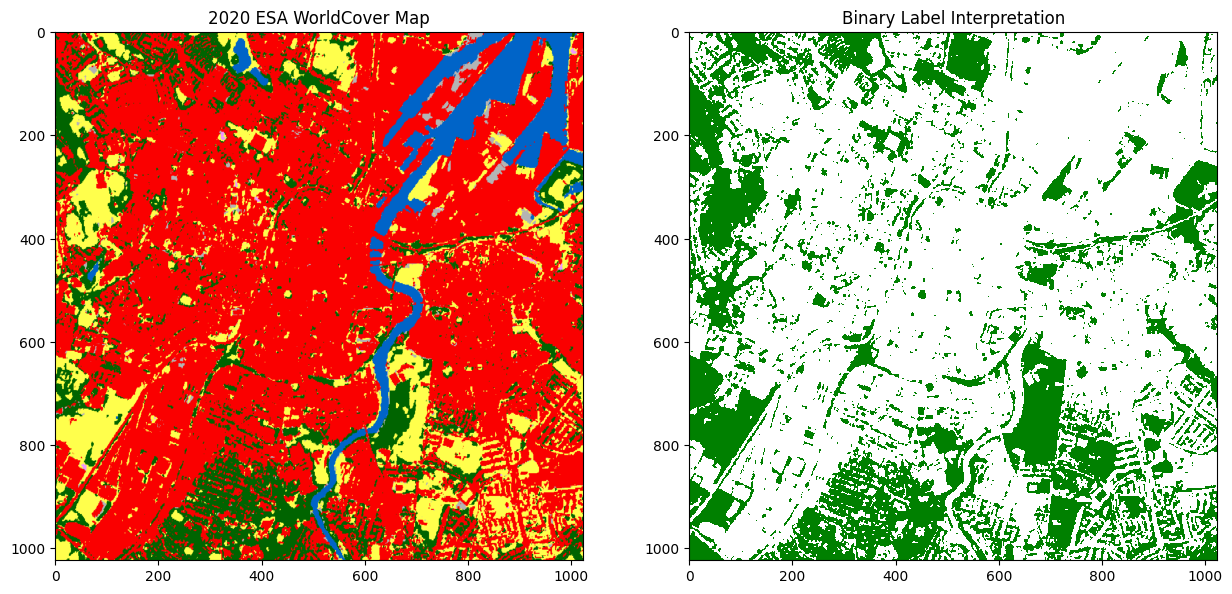

In [7]:
reclassify_worldcover_map()

In [8]:
scene_mask_class_dict = {
    0: (0, 0, 0),       # NODATA - MAGENTA
    1: (255, 0, 0),     # Saturated or Defective - RED
    2: (47, 47, 47),    # Dark Areas - BLACK
    3: (100, 50, 0),    # Cloud Shadow - DARK GREY
    4: (0, 160, 0),     # Vegetation - GREEN
    5: (255, 230, 90),  # Bare Ground - BROWN
    6: (0, 0, 255),     # Water - BLUE
    7: (128, 128, 128), # Unclassified - MAROON
    8: (192, 192, 192), # Cloud - LIGHT GREY
    9: (255, 255, 255), # Definitely Cloud - WHITE
    10: (100, 200, 255),# Thin Cloud - LIGHT BLUE
    11: (255, 150, 255) # Snow or Ice - PINK
}

for i, row in masking_df.iterrows():

    scene_mask = open_image(row.Scene_Mask_path)
    label = open_image(row.Label_path)
    true_colour = open_image(row.True_Colour_path)
    false_colour = open_image(row.False_Colour_path)

    # Create a mask for the unwanted classes
    mask = ((scene_mask==6) | (scene_mask==8) | (scene_mask==9) | (scene_mask==10) | (scene_mask==11))

    # Apply the mask to the images and labels
    masked_true_colour = np.where(np.expand_dims(mask, axis=2), 255, true_colour)
    masked_false_colour = np.where(np.expand_dims(mask, axis=2), 255, false_colour)
    masked_label = np.where(mask, 0, label)

    save_image(masked_true_colour, row.True_Colour_M_path)
    save_image(masked_label, row.True_Colour_M_label_path)

    save_image(masked_false_colour, row.False_Colour_M_path)
    save_image(masked_label, row.False_Colour_M_label_path)


## Image Splitting

In [9]:
split_size = 2 # Splits into 4

# Create the target directory if it doesn't exist
target_directory = "S2_True_Colour_Split"
if not os.path.exists(target_directory):
    os.makedirs(target_directory, exist_ok=True)

# Iterate over each image path
for i, (image_path, label_path) in enumerate(zip(masking_df["True_Colour_M_path"], masking_df["True_Colour_M_label_path"])):
    # Check if the files exist
    if os.path.exists(image_path) and os.path.exists(label_path):
        # Load the images
        img = open_image(image_path)
        label = open_image(label_path)

        chip_id = masking_df.at[i, "chip_id"]

        # Split the images into 16 smaller images
        img_height, img_width, _ = img.shape
        split_height = img_height // split_size
        split_width = img_width // split_size

        for row in range(split_size):
            for col in range(split_size):
                # Calculate the indices for splitting the image
                start_row = row * split_height
                end_row = (row + 1) * split_height
                start_col = col * split_width
                end_col = (col + 1) * split_width

                # Extract the smaller image and label
                split_img = img[start_row:end_row, start_col:end_col, :]
                split_label = label[start_row:end_row, start_col:end_col]

                # Save the smaller images with indexed filenames
                img_filename = f"{chip_id}_{row}_{col}_img.png"
                label_filename = f"{chip_id}_{row}_{col}_label.png"
                img_filepath = os.path.join(target_directory, img_filename)
                label_filepath = os.path.join(target_directory, label_filename)

                # Save the images only if the split_label has a value greater than 0 present
                if np.any(split_label > 0):
                    save_image(split_img, img_filepath)
                    save_image(split_label, label_filepath)
    else:
        print(f"File not found: {image_path} or {label_path}")

# Dataset Generation

## Metadata

In [10]:
# List files in S2_True_Colour_Split
mypath = "/content/drive/MyDrive/Deloitte Analytathon 2024/S2_True_Colour_Split"
files_list = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]

# Create lists for images and labels
labels_list = [x for x in files_list if 'label.png' in x]
images_list = [x for x in files_list if 'img.png' in x]

# Create the DataFrame
metadata_df = pd.DataFrame({'image_path': images_list, 'label_path': labels_list})

# Sort
metadata_df = pd.DataFrame(np.sort(metadata_df.values, axis=0), index=metadata_df.index, columns=metadata_df.columns)
metadata_df
# Jojn Paths
for col in metadata_df.columns:
    metadata_df[col] = "/content/drive/MyDrive/Deloitte Analytathon 2024/S2_True_Colour_Split/" + metadata_df[col]

In [ ]:
metadata_df
image_paths = train_df['image_path'].tolist()
image_paths


## Train and Validation

In [11]:
# Shuffle DataFrame
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

# Perform 90/10 split for train / val
test_df = metadata_df.sample(frac=0.2, random_state=42)
train_df = metadata_df.drop(test_df.index)
len(train_df), len(test_df)
train_df

,image_path,label_path
0,/content/drive/MyDrive/Deloitte Analytathon 20...,/content/drive/MyDrive/Deloitte Analytathon 20...
1,/content/drive/MyDrive/Deloitte Analytathon 20...,/content/drive/MyDrive/Deloitte Analytathon 20...
2,/content/drive/MyDrive/Deloitte Analytathon 20...,/content/drive/MyDrive/Deloitte Analytathon 20...
3,/content/drive/MyDrive/Deloitte Analytathon 20...,/content/drive/MyDrive/Deloitte Analytathon 20...
4,/content/drive/MyDrive/Deloitte Analytathon 20...,/content/drive/MyDrive/Deloitte Analytathon 20...
...,...,...
232,/content/drive/MyDrive/Deloitte Analytathon 20...,/content/drive/MyDrive/Deloitte Analytathon 20...
234,/content/drive/MyDrive/Deloitte Analytathon 20...,/content/drive/MyDrive/Deloitte Analytathon 20...
236,/content/drive/MyDrive/Deloitte Analytathon 20...,/content/drive/MyDrive/Deloitte Analytathon 20...
238,/content/drive/MyDrive/Deloitte Analytathon 20...,/content/drive/MyDrive/Deloitte Analytathon 20...


## Segmentation Classes

In [12]:
select_classes = ['background', 'greenspace']
select_class_indices = [0, 1]
class_rgb_values = [[255, 255, 255], [0, 0, 0]]
select_class_rgb_values = np.array(class_rgb_values)[select_class_indices]

# Function Definitions

In [13]:
# function for data visualization
def visualize(**images):

    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):

    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):

    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):

    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

## GreenSpaceDataset Class

In [14]:
class GreenSpaceDataset(torch.utils.data.Dataset):


    def __init__(
            self,
            df,
            class_rgb_values=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.image_paths = df['image_path'].tolist()
        self.mask_paths = df['label_path'].tolist()

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        # return length of
        return len(self.image_paths)

## Augmentations

In [15]:
def get_training_augmentation():
    train_transform = [
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
    ]
    return album.Compose(train_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):

    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)

# Sample Visualizations

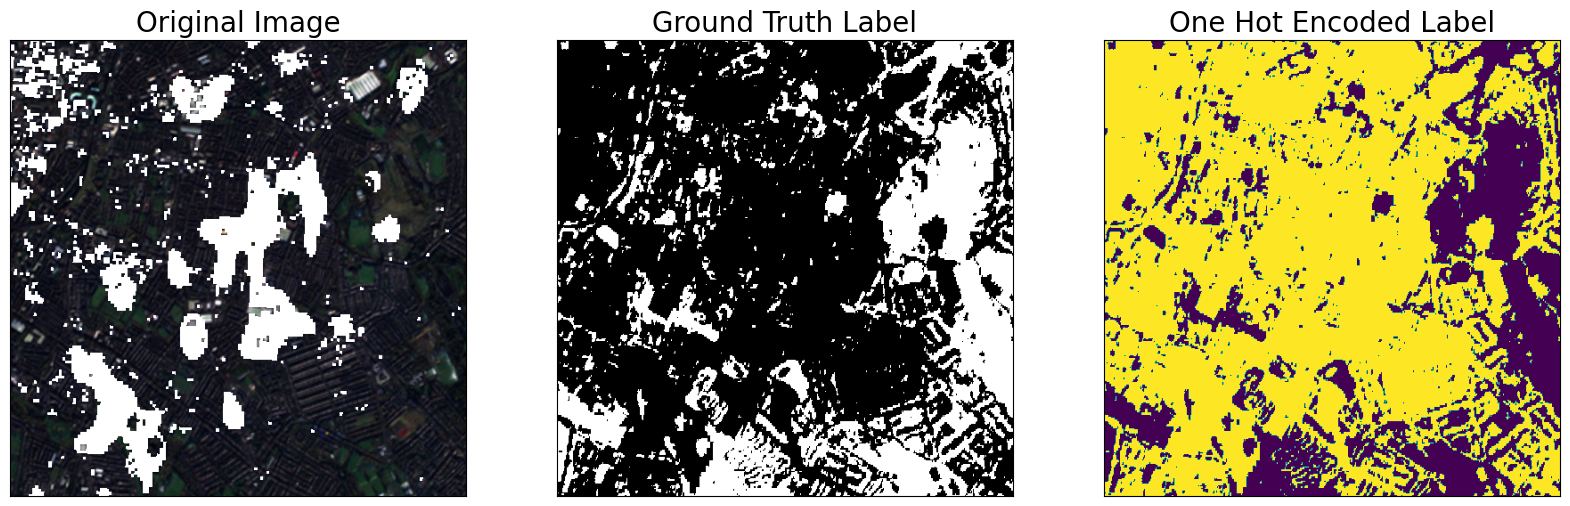

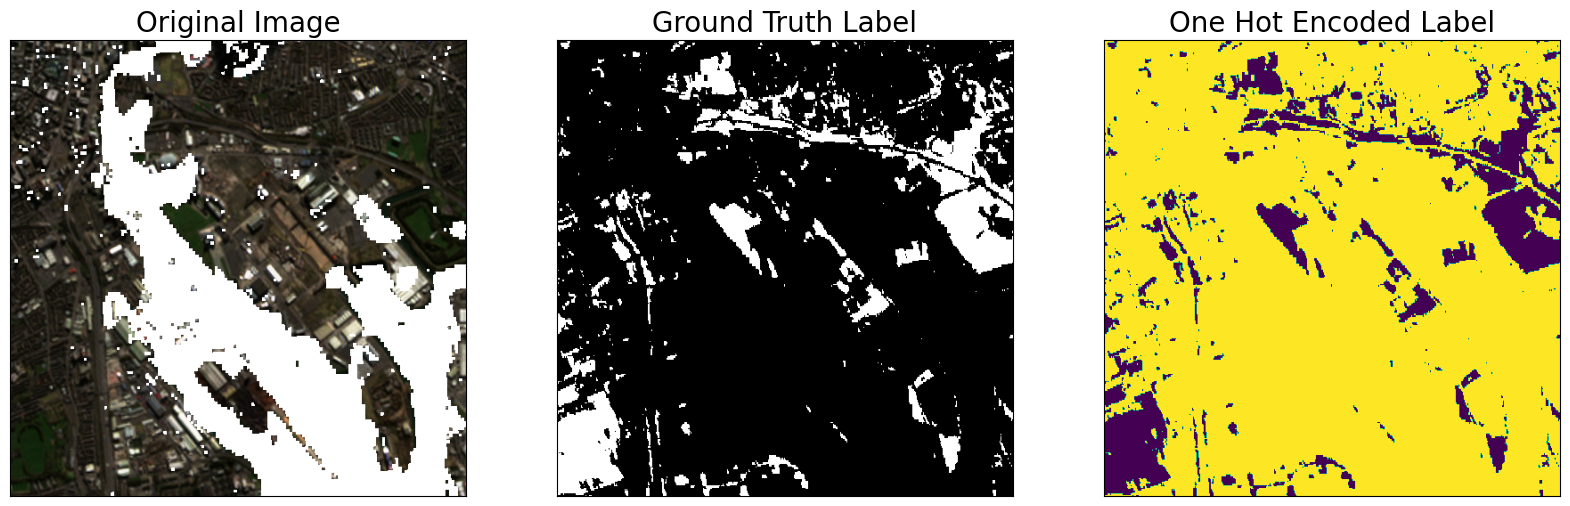

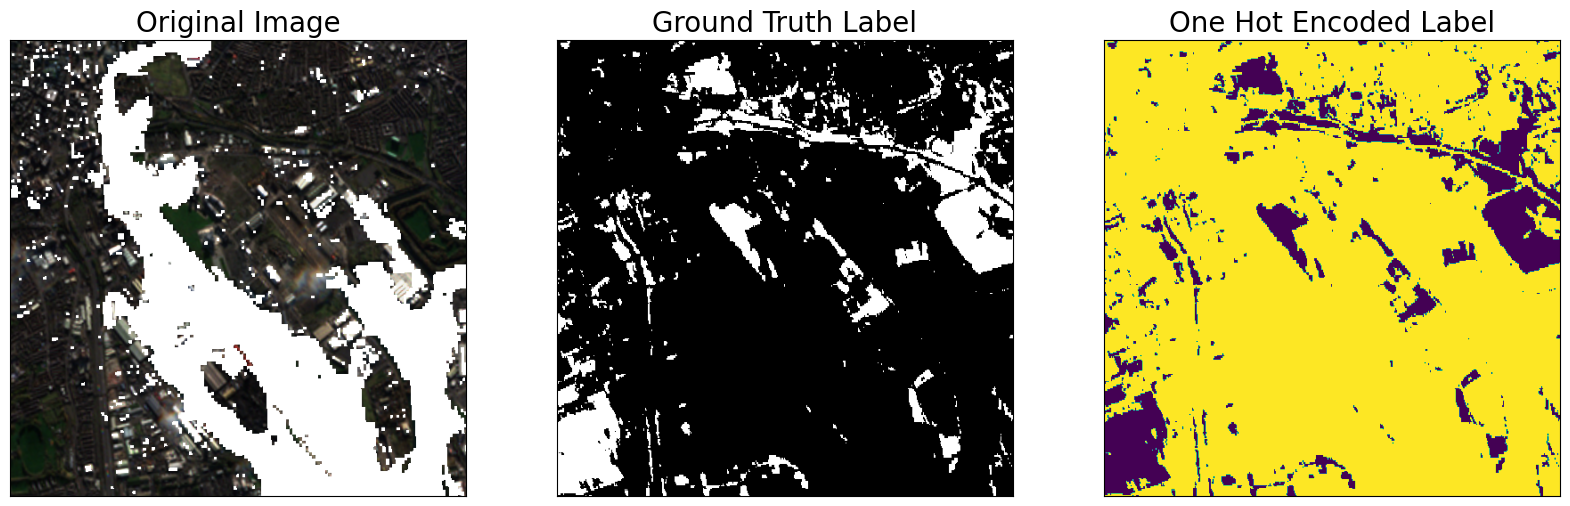

In [16]:
augmented_dataset = GreenSpaceDataset(
    train_df,
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on image/mask pairs
for idx in range(3):
    image, mask = augmented_dataset[idx]
    visualize(
        original_image = image,
        ground_truth_label = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_label = reverse_one_hot(mask)
    )

# Deep Learning

## Model Definition

In [17]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 295MB/s]


## Create DataLoaders

In [18]:
# Get train and val dataset instances
train_dataset = GreenSpaceDataset(
    train_df,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataset = GreenSpaceDataset(
    test_df,
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Hyperparameters

In [19]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 20

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.00008),
])



In [20]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)



## Train

In [21]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)

        train_logs_list.append(train_logs)





Epoch: 0
train:   0%|          | 0/48 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


train: 100%|██████████| 48/48 [00:19<00:00,  2.91it/s, dice_loss - 0.4333, iou_score - 0.5978]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


train: 100%|██████████| 48/48 [00:19<00:00,  2.41it/s, dice_loss - 0.4333, iou_score - 0.5978]

Epoch: 1
train: 100%|██████████| 48/48 [00:19<00:00,  2.47it/s, dice_loss - 0.3139, iou_score - 0.7949]

Epoch: 2
train: 100%|██████████| 48/48 [00:18<00:00,  2.58it/s, dice_loss - 0.2489, iou_score - 0.82]

Epoch: 3
train: 100%|██████████| 48/48 [00:19<00:00,  2.51it/s, dice_loss - 0.2035, iou_score - 0.8258]

Epoch: 4
train: 100%|██████████| 48/48 [00:20<00:00,  2.38it/s, dice_loss - 0.1716, iou_score - 0.8337]

Epoch: 5
train: 100%|██████████| 48/48 [00:19<00:00,  2.44it/s, dice_loss - 0.152, iou_score - 0.8401]

Epoch: 6
train: 100%|██████████| 48/48 [00:19<00:00,  2.43it/s, dice_loss - 0.1383, iou_score - 0.8445]

Epoch: 7
train: 100%|██████████| 48/48 [00:19<00:00,  2.50it/s, dice_loss - 0.1268, iou_score - 0.8493]

Epoch: 8
train: 100%|██████████| 48/48 [00:19<00:00,  2.47it/s, dice_loss - 0.1183, iou_score - 0.8531]

Epoch: 9
train: 100%|██████████| 48/48 [00:20<00:00,  2.37it/s, dic

## Predict Test Data

In [22]:
# create test dataloader to be used with DeepLabV3+ model (with preprocessing operation: to_tensor(...))
test_dataset = GreenSpaceDataset(
    test_df,
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing augmentations & transformations)
test_dataset_vis = GreenSpaceDataset(
    test_df,
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]


In [23]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

### Model Evaluation on Test Dataset

In [24]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 48/48 [00:03<00:00, 12.10it/s, dice_loss - 0.08557, iou_score - 0.8671]
Evaluation on Test Data: 
Mean IoU Score: 0.8671
Mean Dice Loss: 0.0856


### Plot Dice Loss & IoU Metric for Train vs. Val

In [25]:
train_logs_df = pd.DataFrame(train_logs_list)
train_logs_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
dice_loss,0.433285,0.313901,0.248930,0.203529,0.171591,0.151969,0.138348,0.126755,0.118291,0.111544,0.106464,0.102007,0.097111,0.094201,0.091668,0.088967,0.086590,0.084942,0.083284,0.080404
iou_score,0.597787,0.794937,0.820021,0.825754,0.833672,0.840101,0.844510,0.849252,0.853147,0.855772,0.857895,0.860011,0.863459,0.864490,0.866065,0.867888,0.869512,0.870136,0.871690,0.874591


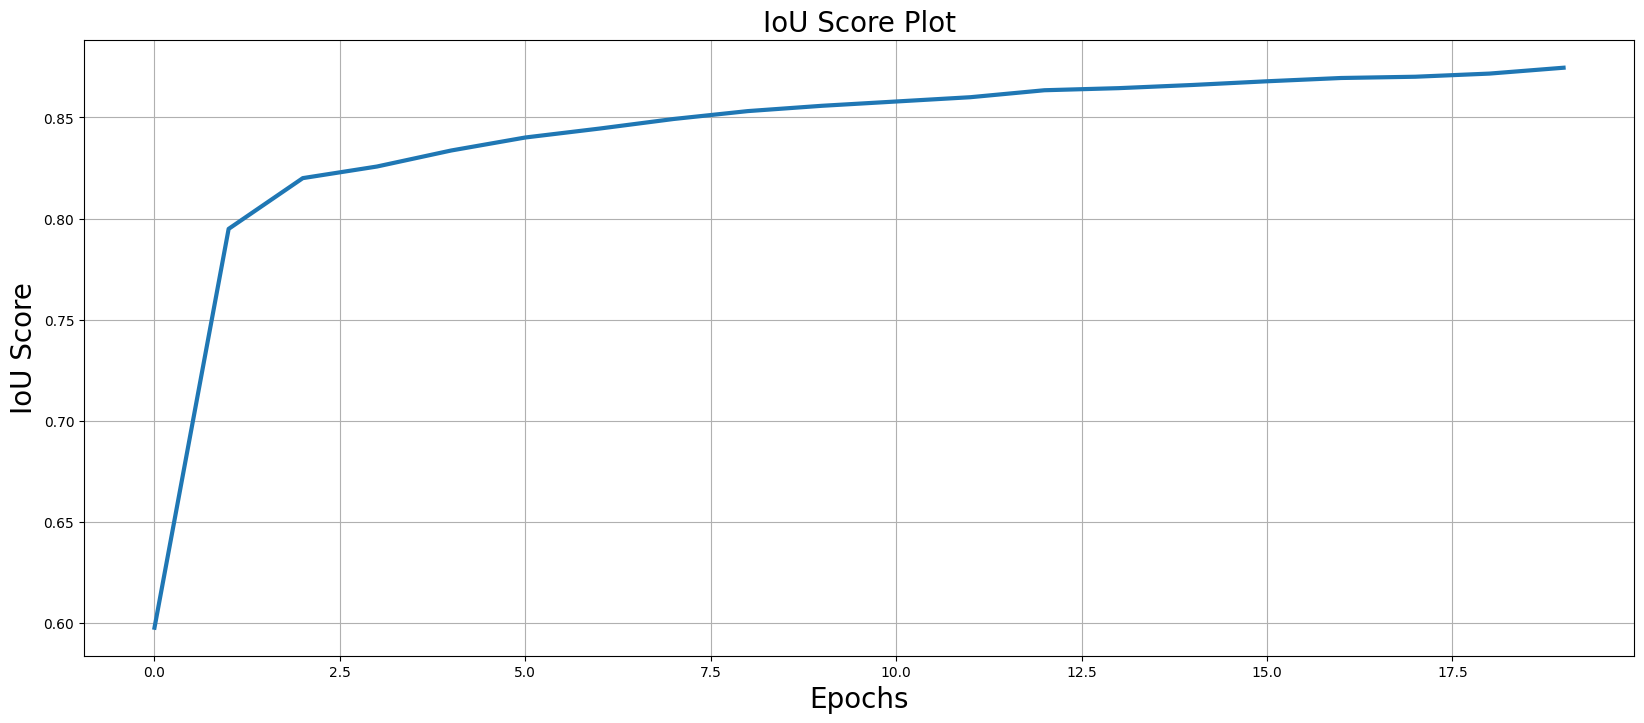

In [26]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

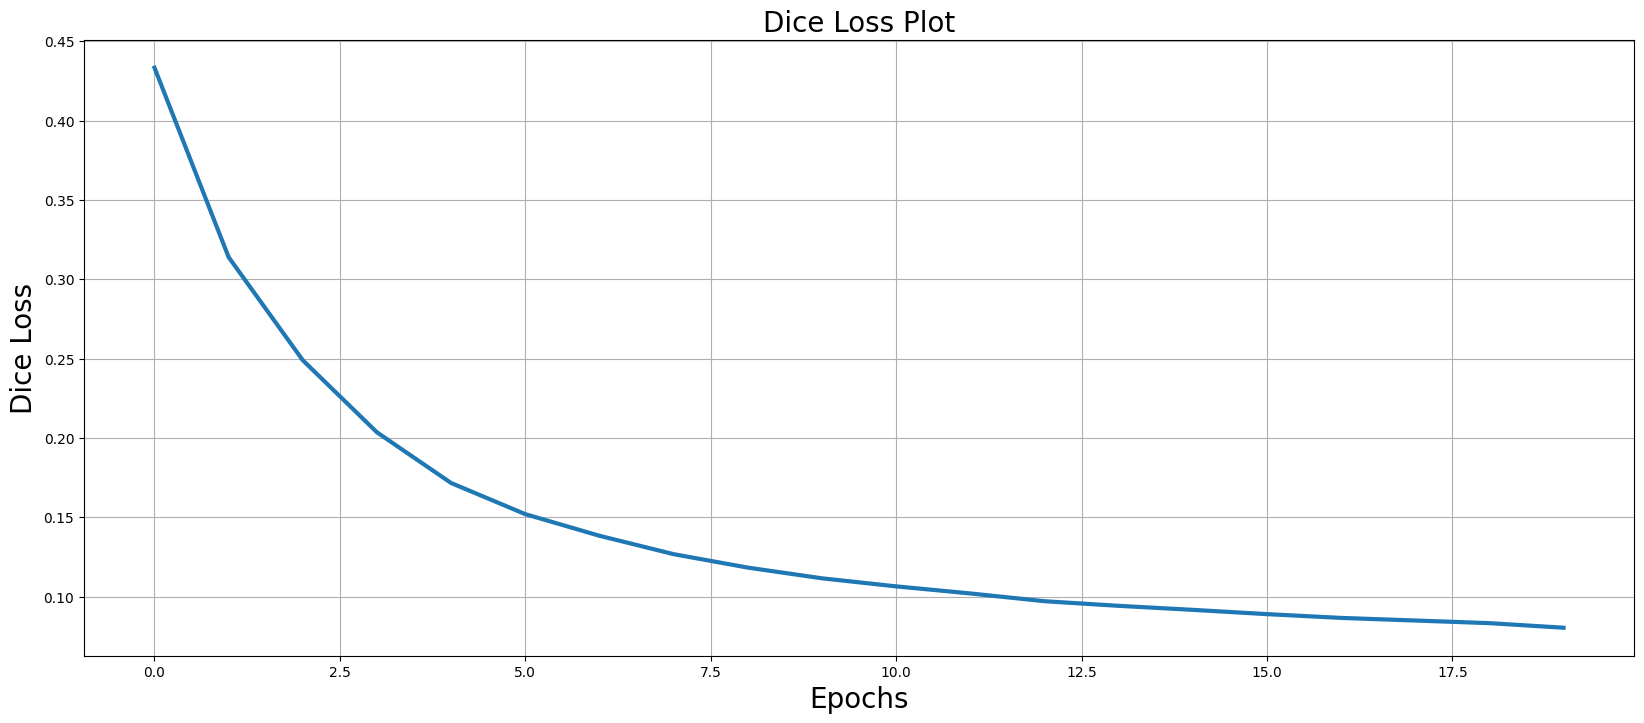

In [27]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()